In [1]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from modules import train_model, test_model
from dataset import BPDataset
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
from backbone_models import ResNet18, VGG16, shallowResNet, shallowResNet2,ResNet3, FCNet, Conv3Net
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ppg_dir = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/0_subject'
label_path = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/PPG-BP dataset.csv'

In [9]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = BPDataset(ppg_dir, label_path, normalize=data_normalization,choose_class=[0,2])
dataset_size=dataset.__len__()
print('dataset: {}'.format(dataset.__len__()))


# Split training data, validation data, testing data
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [256, 64, 79])#[312, 78, 97])#[256, 64, 79]#[415, 104, 129]
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

dataset: 399
256
64
79


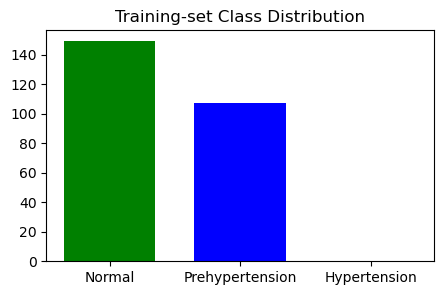

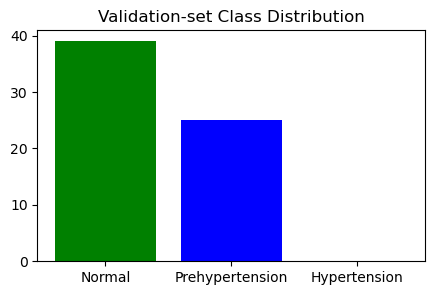

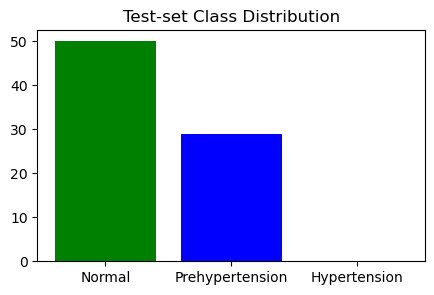

In [10]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1
    else:
        train_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),train_labels,color=['g','b','r'],width=0.7)
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1
    else:
        val_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),val_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1
    else:
        test_labels[2]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(3),test_labels,color=['g','b','r'])
plt.xticks(np.arange(3),['Normal','Prehypertension','Hypertension'])
plt.title('Test-set Class Distribution')
plt.show()


In [19]:
train_labels

[149, 107, 0]

In [11]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=16,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=16,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=16,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cpu


In [12]:
class Conv3Net(nn.Module):
    def __init__(self, n_class=2):
        super(Conv3Net, self).__init__()
        self.n_class = n_class
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=30, stride=3, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=15, stride=3, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, n_class)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [13]:
#model=FCNet(3)
model=Conv3Net(2)
#model=ResNet18(2)
model=model.to(device)

In [14]:
model

Conv3Net(
  (feature_extractor): Sequential(
    (0): Conv1d(1, 64, kernel_size=(30,), stride=(3,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(15,), stride=(3,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

Epoch 0/179
----------
train Loss: 0.6662 Acc: 0.5820
val Loss: 0.6253 Acc: 0.6094

Epoch 1/179
----------
train Loss: 0.6744 Acc: 0.5234
val Loss: 0.6321 Acc: 0.5625

Epoch 2/179
----------
train Loss: 0.6381 Acc: 0.5898
val Loss: 0.6117 Acc: 0.5938

Epoch 3/179
----------
train Loss: 0.6256 Acc: 0.6328
val Loss: 0.6176 Acc: 0.5469

Epoch 4/179
----------
train Loss: 0.6102 Acc: 0.5898
val Loss: 0.5949 Acc: 0.5938

Epoch 5/179
----------
train Loss: 0.6230 Acc: 0.5742
val Loss: 0.6114 Acc: 0.5000

Epoch 6/179
----------
train Loss: 0.6353 Acc: 0.6289
val Loss: 0.6098 Acc: 0.5781

Epoch 7/179
----------
train Loss: 0.6252 Acc: 0.6289
val Loss: 0.5997 Acc: 0.6250

Epoch 8/179
----------
train Loss: 0.6088 Acc: 0.6289
val Loss: 0.5994 Acc: 0.5938

Epoch 9/179
----------
train Loss: 0.6003 Acc: 0.6055
val Loss: 0.6080 Acc: 0.5625

Epoch 10/179
----------
train Loss: 0.6102 Acc: 0.6016
val Loss: 0.5880 Acc: 0.6406

Epoch 11/179
----------
train Loss: 0.6294 Acc: 0.6211
val Loss: 0.6038 Acc

train Loss: 0.1925 Acc: 0.9297
val Loss: 0.7688 Acc: 0.6562

Epoch 98/179
----------
train Loss: 0.1569 Acc: 0.9453
val Loss: 0.7520 Acc: 0.6562

Epoch 99/179
----------
train Loss: 0.1532 Acc: 0.9570
val Loss: 0.7456 Acc: 0.6406

Epoch 100/179
----------
train Loss: 0.1745 Acc: 0.9453
val Loss: 0.7547 Acc: 0.6406

Epoch 101/179
----------
train Loss: 0.1661 Acc: 0.9258
val Loss: 0.7763 Acc: 0.6094

Epoch 102/179
----------
train Loss: 0.1520 Acc: 0.9492
val Loss: 0.7632 Acc: 0.6094

Epoch 103/179
----------
train Loss: 0.1697 Acc: 0.9453
val Loss: 0.7489 Acc: 0.6250

Epoch 104/179
----------
train Loss: 0.1813 Acc: 0.9219
val Loss: 0.7960 Acc: 0.6094

Epoch 105/179
----------
train Loss: 0.1566 Acc: 0.9453
val Loss: 0.7676 Acc: 0.6406

Epoch 106/179
----------
train Loss: 0.1637 Acc: 0.9492
val Loss: 0.7374 Acc: 0.6562

Epoch 107/179
----------
train Loss: 0.1373 Acc: 0.9570
val Loss: 0.7699 Acc: 0.6094

Epoch 108/179
----------
train Loss: 0.1672 Acc: 0.9492
val Loss: 0.8437 Acc: 0.6

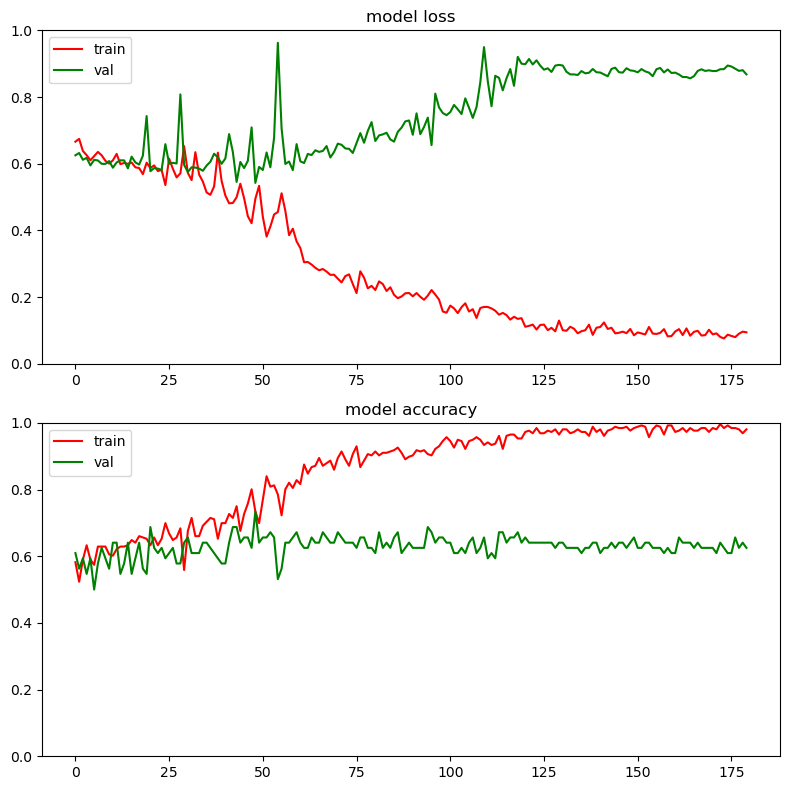

In [15]:
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=0.01
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
trained_model,trained_model_later=train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=180)

In [16]:
from sklearn.metrics import confusion_matrix

def test_model(model,dataloaders,dataset_size,classes,device):
    
    model=model.to(device)
    model.eval()
    corrects=0
    CM=0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels, subject= data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) 
            preds = torch.argmax(outputs.data, 1)

            cm_tmp=confusion_matrix(labels.tolist(), preds.tolist(),labels=classes)
            CM+=cm_tmp
            
            corrects += torch.sum(preds == labels.data)
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)    
        acc=corrects.double() / dataset_size
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print('Confusion Matrix: ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
                
    return acc, CM

device_cpu=torch.device('cpu')

print('- model')
acc1,cm1=test_model(trained_model,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

print('- model_later')
acc2,cm2=test_model(trained_model_later,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

- model

Testset Accuracy(mean): 74.683544 %
Confusion Matrix: 
[[42  8]
 [12 17]]
- Sensitivity :  58.620689655172406
- Specificity :  84.0
- Precision:  68.0
- NPV:  77.77777777777779
- F1 :  62.962962962962955
- model_later

Testset Accuracy(mean): 74.683544 %
Confusion Matrix: 
[[42  8]
 [12 17]]
- Sensitivity :  58.620689655172406
- Specificity :  84.0
- Precision:  68.0
- NPV:  77.77777777777779
- F1 :  62.962962962962955


In [18]:
model_path='/Users/yeseullee/Documents/ECE271B/project/models/'
model_name='shallowPPG_[0,2]_'
torch.save(trained_model.state_dict(),model_path+model_name+datetime.today().strftime('%m-%d-%H:%M')+'.pt')
#torch.save(trained_model_later.state_dict(),model_path+model_name+'later_'+datetime.today().strftime('%m-%d-%H:%M')+'.pt')